In [1]:
!pip install patchify

# Import Libraries

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from patchify import patchify
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt

# Hyperparameters

In [3]:
img_size = 224
num_channels = 3
patch_size = 25
num_patches = (img_size // patch_size) ** 2
flat_patches_shape = (num_patches, patch_size * patch_size * num_channels)

batch_size = 32
lr = 1e-4
num_epochs = 10
num_classes = 2
class_names = ['bleeding', 'non-bleeding']

# Load Data

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

if not os.path.exists('files'):
    os.makedirs('files')

PATH = '/kaggle/input/wcebleedgen/WCEBleedGen'
model_path = os.path.join('files', 'model.h5')
log_path = os.path.join('files', 'log.csv')

# Train / Validation Dataset

In [5]:
bleed_images = glob(os.path.join(PATH, 'bleeding/Images', '*.png'))
nonbleed_images = glob(os.path.join(PATH, 'non-bleeding/images', '*.png'))

if not bleed_images or not nonbleed_images:
    raise ValueError("No images found in 'bleed' or 'nonbleed' folders.")

bleed_images = shuffle(bleed_images, random_state=42)
nonbleed_images = shuffle(nonbleed_images, random_state=42)

train = bleed_images + nonbleed_images
train_x, valid_x = train_test_split(train, test_size=0.1, random_state=42)

train_x = shuffle(train_x, random_state=42)
valid_x = shuffle(valid_x, random_state=42)

print(f"Total: {len(bleed_images)+len(nonbleed_images)}, Train: {len(train_x)}, Validation: {len(valid_x)}")

Total: 2618, Train: 2356, Validation: 262


# Process Images, Patches and Labels

In [6]:
def process_img_label(path):
    """Reading Images"""
    path = path.decode()
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_size, img_size))
    img = img/255.0
    
    """Patches"""
    patch_shape = (patch_size, patch_size, num_channels)
    patches = patchify(img, patch_shape, patch_size)
    patches = np.reshape(patches, flat_patches_shape)
    patches = patches.astype(np.float32)
    
    """Labels"""
    class_name = path.split('/')[-3]
    class_idx = class_names.index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)
    return patches, class_idx

In [7]:
def parse(path):
    patches, labels = tf.numpy_function(process_img_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, num_classes)
    
    patches.set_shape(flat_patches_shape)
    labels.set_shape(num_classes)
    
    return patches, labels

In [8]:
def tf_dataset(images, batch=32):
    data = tf.data.Dataset.from_tensor_slices((images))
    data = data.map(parse).batch(batch).prefetch(8)
    return data

# ViT Model

In [9]:
"""ViT Model Hyperparameters"""
num_layers = 12
hidden_dim = 768
mlp_dim = 3072
num_heads = 12
dropout_rate = 0.1

In [10]:
class ClassToken(Layer):
    def __init__(self):
        super().__init__()
    
    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1,1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )
    
    def call(self, inputs):
        batch_size__ = tf.shape(inputs)[0]
        hidden_dim__ = self.w.shape[-1]
        
        cls = tf.broadcast_to(self.w, [batch_size__, 1, hidden_dim__])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

In [11]:
def mlp(x):
    x = Dense(mlp_dim, activation="gelu")(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(hidden_dim)(x)
    x = Dropout(dropout_rate)(x)
    return x

In [12]:
def transformer_encoder(x):
    skip1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=num_heads, key_dim=hidden_dim
    )(x, x)
    x = Add()([x, skip1])
    skip2 = x
    x = LayerNormalization()(x)
    x = mlp(x)
    x = Add()([x, skip2])
    
    return x

In [13]:
def ViT():
    """Input"""
    input_shape = (num_patches, patch_size*patch_size*num_channels)
    inputs = Input(input_shape)
    
    """Patch + Embeddings"""
    patch_embed = Dense(hidden_dim)(inputs)
    
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embed = Embedding(input_dim=num_patches, output_dim=hidden_dim)(positions)
    
    embed = patch_embed + pos_embed
    
    """Adding Class Token"""
    token = ClassToken()(embed)
    x = Concatenate(axis=1)([token, embed])
    
    for _ in range(num_layers):
        x = transformer_encoder(x)
    
    """Classification Head"""
    x = LayerNormalization()(x)
    x = x[:, 0, :]
    
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, x)
    return model

# Training

In [14]:
strategy = tf.distribute.MirroredStrategy()

In [15]:
batch_size = batch_size * strategy.num_replicas_in_sync

In [16]:
train_data = tf_dataset(train_x, batch=batch_size)
valid_data = tf_dataset(valid_x, batch=batch_size)

In [17]:
with strategy.scope():
    model = ViT()
    model.compile(loss='categorical_crossentropy', 
             optimizer=tf.keras.optimizers.Adam(lr, clipvalue=1.0),
             metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 1875)]   0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64, 768)      1440768     input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 64, 768)      0           dense[0][0]                      
__________________________________________________________________________________________________
class_token (ClassToken)        (None, 1, 768)       768         tf.__operators__.add[0][0]       
______________________________________________________________________________________________

In [18]:
callbacks = [
    ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1),
    CSVLogger(log_path),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False),
]

model.fit(
    train_data,
    epochs=num_epochs,
    validation_data=valid_data,
    callbacks=callbacks
)

Epoch 1/10
74/74 [==============================] - 90s 1s/step - loss: 1.0619 - acc: 0.5153 - val_loss: 0.7371 - val_acc: 0.4962

Epoch 00001: val_loss improved from inf to 0.73706, saving model to files/model.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
74/74 [==============================] - 73s 983ms/step - loss: 0.4885 - acc: 0.7534 - val_loss: 0.1942 - val_acc: 0.9237

Epoch 00002: val_loss improved from 0.73706 to 0.19415, saving model to files/model.h5
Epoch 3/10
74/74 [==============================] - 73s 980ms/step - loss: 0.1477 - acc: 0.9431 - val_loss: 0.0790 - val_acc: 0.9656

Epoch 00003: val_loss improved from 0.19415 to 0.07903, saving model to files/model.h5
Epoch 4/10
74/74 [==============================] - 73s 979ms/step - loss: 0.0959 - acc: 0.9686 - val_loss: 0.0619 - val_acc: 0.9809

Epoch 00004: val_loss improved from 0.07903 to 0.06195, saving model to files/model.h5
Epoch 5/10
74/74 [==============================] - 73s 979ms/step - loss: 0.0908 - acc: 0.9699 - val_loss: 0.0618 - val_acc: 0.9809

Epoch 00005: val_loss improved from 0.06195 to 0.06175, saving model to files/model.h5
Epoch 6/10
74/74 [==============================] - 73s 980ms/step - loss: 0.0621 - acc: 0.9817 - val_loss: 0.1810 -

# Loss and Validation Plots

In [19]:
df = pd.read_csv('/kaggle/working/files/log.csv')
df # training log

,epoch,acc,loss,lr,val_acc,val_loss
0,0,0.515280,1.061890,0.0001,0.496183,0.737058
1,1,0.753396,0.488511,0.0001,0.923664,0.194154
2,2,0.943124,0.147721,0.0001,0.965649,0.079026
3,3,0.968591,0.095882,0.0001,0.980916,0.061947
4,4,0.969864,0.090754,0.0001,0.980916,0.061751
5,5,0.981749,0.062078,0.0001,0.938931,0.181006
6,6,0.973684,0.077398,0.0001,0.992366,0.034005
7,7,0.968166,0.106924,0.0001,0.935115,0.146208
8,8,0.981324,0.059509,0.0001,0.984733,0.040221
9,9,0.989813,0.038240,0.0001,0.977099,0.066455


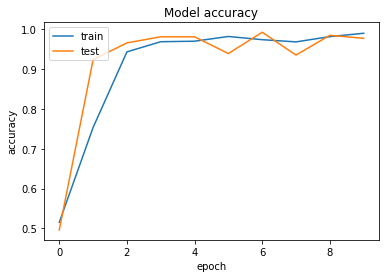

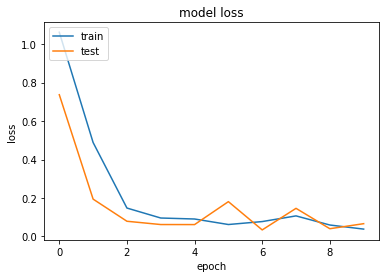

In [20]:
plt.plot(df['acc'])
plt.plot(df['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(df['loss'])
plt.plot(df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing Data

In [21]:
TEST_PATH = '/kaggle/input/bleedgen-test-data/Auto-WCEBleedGen Challenge Test Dataset'
test_data_1 = glob(os.path.join(TEST_PATH, 'Test Dataset 1', '*.png'))
test_data_2 = glob(os.path.join(TEST_PATH, 'Test Dataset 2', '*.png'))

test_data = test_data_1 + test_data_2

In [22]:
model.load_weights(model_path)

In [23]:
predicted_df = pd.DataFrame(columns=['ID', 'Predicted_Class'])

In [24]:
def predict_single_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_size, img_size))
    img = img/255.0
    
    patch_shape = (patch_size, patch_size, num_channels)
    patches = patchify(img, patch_shape, patch_size)
    patches = np.reshape(patches, flat_patches_shape)
    patches = patches.astype(np.float32)
    
    patches = tf.expand_dims(patches, axis=0)
    
    predictions = model.predict(patches)
    predicted_class = np.argmax(predictions, axis=-1)[0]
    
    return predicted_class

In [25]:
for image_path in test_data:
    image_id = os.path.basename(image_path)
    predicted_class = predict_single_image(image_path)
    
    predicted_df = predicted_df.append(
                    {
                        'ID': image_id,
                        'Predicted_Class': class_names[predicted_class]
                    },
                    ignore_index=True)

In [26]:
predicted_df.to_csv('predictions.csv', index=False)

# Accuracy, Recall, F1-Score
## on Validation Dataset

In [27]:
valid_x[0].split('/')[-3], class_names[predict_single_image(test_data[0])]

('non-bleeding', 'non-bleeding')

In [28]:
y_true = []
y_pred = []
for i, p in enumerate(valid_x):
    y = valid_x[i]
    y_true.append(y.split('/')[-3])
for i, j in enumerate(valid_x):
    y_pred.append(class_names[predict_single_image(valid_x[i])])

In [29]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    bleeding       1.00      0.98      0.99       130
non-bleeding       0.99      1.00      0.99       132

    accuracy                           0.99       262
   macro avg       0.99      0.99      0.99       262
weighted avg       0.99      0.99      0.99       262



In [30]:
cm = confusion_matrix(y_true, y_pred)

In [31]:
print(cm)

[[128   2]
 [  0 132]]
